201911012 Yeong jae Kong

(1) Run the code below and arrange the results.
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-autoexamples-cluster-plot-cluster-comparison-py 


Automatically created module for IPython interactive environment


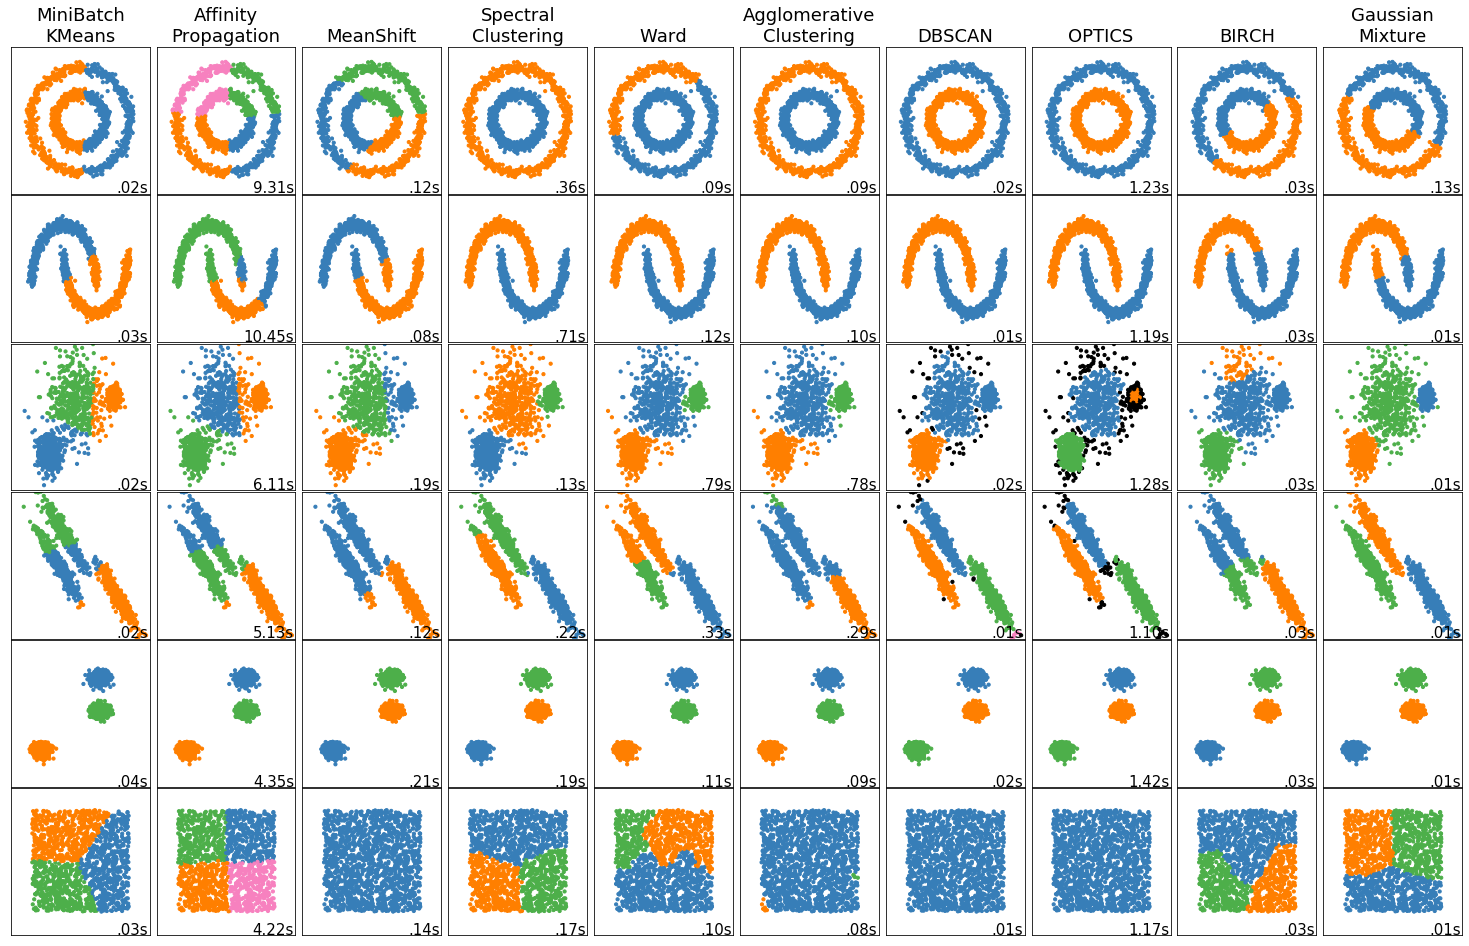

In [113]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

(2) Randomly sample 100 images for each class (total 1000 images) from the MNIST training data set.

In [119]:
import numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

def samples(x,y):
    temp = []
    data = []
    label = []
    for i in range(len(y)):
        temp.append([x[i],y[i]])
    np.random.shuffle(temp)
    for i in range(10):
        k = 0
        for j in range(len(temp)):
            if k >= 100:
                break
            if temp[j][1] == i:
                data.append(temp[j][0])
                label.append(temp[j][1])
                k += 1
    return np.array(data), np.array(label)

x_train, y_train = samples(x_train, y_train)
print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Training Data: (1000, 28, 28)
Training Labels: (1000,)


(3) For 1000 images, perform Agglomerative clustering, k-means clustering, Gaussian mixture model,
Spectral clustering. (i.e., k = 10) 

In [130]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

x_train = x_train.reshape(len(x_train),-1)
X = x_train.astype(float) / 255.
Y = y_train

def retrieve_info(cluster_labels, y_train):
    reference_labels = {}
    for i in range(10):
        index = np.where(cluster_labels == i,1,0)
        reference_labels[i] = np.bincount(y_train[index==1]).argmax()
    return reference_labels

#agc
agc = AgglomerativeClustering(n_clusters=10)
agc = agc.fit(X)
y_pred_agc = agc.labels_

reference_labels = retrieve_info(y_pred_agc, y_train)
number_labels = np.random.rand(len(y_pred_agc))
for i in range(len(y_pred_agc)):
    number_labels[i] = reference_labels[y_pred_agc[i]]
    
print(number_labels[:20].astype(int))
print(y_train[:20])
print("accuracy of agc: ", accuracy_score(number_labels, y_train))

#kmeans
kmeans = MiniBatchKMeans(n_clusters = 10)
kmeans.fit(X)
y_pred_kmeans = kmeans.labels_

reference_labels = retrieve_info(y_pred_kmeans, y_train)
number_labels = np.random.rand(len(y_pred_kmeans))
for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]
print(number_labels[:20].astype(int))
print(y_train[:20])
print("accuracy of kmeans: ", accuracy_score(number_labels, y_train))

#gmm
gmm = GaussianMixture(n_components=10)
gmm = gmm.fit(X)
y_pred_gmm = gmm.predict(X)

reference_labels = retrieve_info(y_pred_gmm, y_train)
number_labels = np.random.rand(len(y_pred_gmm))
for i in range(len(y_pred_gmm)):
    number_labels[i] = reference_labels[y_pred_gmm[i]]
    
print(number_labels[:20].astype(int))
print(y_train[:20])
print("accuracy of gmm: ", accuracy_score(number_labels, y_train))

#spc
spc = SpectralClustering(n_clusters=10, affinity='nearest_neighbors')
spc = spc.fit(X)
y_pred_spc = spc.labels_

reference_labels = retrieve_info(y_pred_spc, y_train)
number_labels = np.random.rand(len(y_pred_spc))
for i in range(len(y_pred_spc)):
    number_labels[i] = reference_labels[y_pred_spc[i]]
    
print(number_labels[:20].astype(int))
print(y_train[:20])
print("accuracy of spc: ", accuracy_score(number_labels, y_train))




[0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
accuracy of agc:  0.652
[0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 9 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
accuracy of kmeans:  0.52
[5 5 0 0 5 0 0 0 5 5 0 3 0 5 5 0 0 5 5 5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
accuracy of gmm:  0.539
[0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
accuracy of spc:  0.659


(4) Classify the MNIST test data set using each clustering model and provide accuracy. Explain your
findings. 

In [133]:
# Classify the MNIST test data set using K-means clustering / provide accuracy

X = x_test.reshape(len(x_test), -1).astype(float)/255

kmeans = MiniBatchKMeans(n_clusters = 10)
kmeans.fit(X)
y_pred_kmeans = kmeans.labels_

reference_labels = retrieve_info(y_pred_kmeans, y_test)
number_labels = np.random.rand(len(y_pred_kmeans))
for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]
    
print(number_labels[:20].astype(int))
print(y_test[:20])
print("accuracy of kmeans: ", accuracy_score(number_labels, y_test))

# Classify the MNIST test data set using Gaussian mixture model / provide accuracy

X = x_test.reshape(len(x_test), -1).astype(float)/255

gmm = GaussianMixture(n_components=10)
gmm = gmm.fit(X)
y_pred_gmm = gmm.predict(X)

reference_labels = retrieve_info(y_pred_gmm, y_test)
number_labels = np.random.rand(len(y_pred_gmm))
for i in range(len(y_pred_gmm)):
    number_labels[i] = reference_labels[y_pred_gmm[i]]
    
print(number_labels[:20].astype(int))
print(y_test[:20])
print("accuracy of gmm: ", accuracy_score(number_labels, y_test))

[7 3 1 0 4 1 7 4 4 7 0 6 7 0 1 3 4 7 3 4]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
accuracy of kmeans:  0.5787
[9 3 1 0 9 1 9 4 4 7 0 6 9 0 1 3 9 9 3 9]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
accuracy of gmm:  0.597


Conclusion : All models showed an accuracy of more than 50% in general, but agglomerative clustering and spectral clustering showed an accuracy close to 65%. Although it varies according to the parameter value, it can be seen that agglomerative clustering and spectral clustering generally show high performance in MNIST Classifying. Also, due to the characteristics of the clustering method, it was difficult to distinguish numbers of similar shapes such as {7, 4, 9} and {3, 5}.